In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## Data preparation

In [2]:
cities = pd.read_csv('data/city.csv')
cities.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000,2200,UTC+7,53.347997,83.779806,635585,1730


In [3]:
def str2int(population: str):
    if population.endswith(']'):
        return int(population[:-3])
    else:
        return int(population)

cities.loc[:, 'population'] = list(map(str2int, cities.population))
cities = cities[['address', 'geo_lat', 'geo_lon', 'population']]

cities30 = cities.sort_values(by='population', ascending=False).head(30)
cities30.reset_index(inplace=True, drop=True)
cities30.head()

,address,geo_lat,geo_lon,population
0,г Москва,55.754047,37.620405,11514330
1,г Санкт-Петербург,59.939131,30.315900,4848742
2,г Новосибирск,55.028191,82.921149,1498921
3,г Екатеринбург,56.838522,60.605491,1377738
4,г Нижний Новгород,56.324063,44.005391,1250615


In [4]:
import geopy.distance

def get_distance(coords1: tuple, coords2: tuple):
    return geopy.distance.geodesic(coords1, coords2).km

In [5]:
f_dist, s_dist = cities30[['geo_lat', 'geo_lon']].iloc[:2].values
print(f_dist, s_dist)
print(get_distance(f_dist, s_dist))

[55.7540471 37.620405 ] [59.9391313 30.3159004]
636.0231024849263


## Optimization

In [6]:
cities30.head()

,address,geo_lat,geo_lon,population
0,г Москва,55.754047,37.620405,11514330
1,г Санкт-Петербург,59.939131,30.315900,4848742
2,г Новосибирск,55.028191,82.921149,1498921
3,г Екатеринбург,56.838522,60.605491,1377738
4,г Нижний Новгород,56.324063,44.005391,1250615


In [25]:
def compute_path_distance(data: pd.DataFrame, path: np.ndarray) -> float:
    total_dist = 0
    for i in range(1, len(path)):
        prev_coords = data[['geo_lat', 'geo_lon']].iloc[path[i - 1]].values
        cur_coords = data[['geo_lat', 'geo_lon']].iloc[path[i]].values
        total_dist += np.abs(get_distance(prev_coords, cur_coords))
    return total_dist

def acceptance_prob(old_dist: float, new_dist: float, temp: float) -> float:
    return 1.0 if new_dist < old_dist else np.exp((old_dist - new_dist) / temp)

def optimize(data: pd.DataFrame, annealing_rate=0.95) -> (float, np.ndarray):
    annealing_rate = annealing_rate
    annealing_schedule = 7
    city_idx_range = list(range(30))

    cur_path = np.random.choice(data.index.values, size=data.index.size, 
                                 replace=False)
    cur_dist = compute_path_distance(data, cur_path)
    temp, t = cur_dist, 0

    path_evolutions = []
    while temp > 1e-2:
        # select cities to swap
        from_id, to_id = np.random.choice(city_idx_range, size=2, replace=False)
        # make swap and create new path
        new_path = cur_path.copy()
        new_path[from_id], new_path[to_id] = new_path[to_id], new_path[from_id]
        
        new_dist = compute_path_distance(data, new_path)
        cur_dist = compute_path_distance(data, cur_path)
        
        ap = acceptance_prob(cur_dist, new_dist, temp)
        if ap > np.random.rand():
            cur_path = new_path
            cur_dist = new_dist

        if t > 0 and t % annealing_schedule == 0:
            # temperature annealing and distance reporting
            print(f'Temperature = {temp} | Best distance = {cur_dist}')
            temp *= annealing_rate
            path_evolutions.append(cur_path)

        t += 1
    
    print(f'Final Temperature = {temp} | Final Best distance = {cur_dist}')
    return cur_dist, cur_path, path_evolutions

### Slow cooling

In [30]:
%%time
best_dist, best_path, path_evolutions = optimize(cities30, 0.92)

Temperature = 56051.65503256185 | Best distance = 61108.25114208722
Temperature = 51567.522629956904 | Best distance = 54596.081382964454
Temperature = 47442.120819560354 | Best distance = 48742.27259479689
Temperature = 43646.75115399553 | Best distance = 55812.75169359507
Temperature = 40155.01106167589 | Best distance = 55232.71612106013
Temperature = 36942.61017674182 | Best distance = 53968.84146600021
Temperature = 33987.20136260248 | Best distance = 57902.46584905109
Temperature = 31268.225253594283 | Best distance = 62089.06537248804
Temperature = 28766.767233306742 | Best distance = 50248.32422387004
Temperature = 26465.425854642202 | Best distance = 54800.64074283589
Temperature = 24348.19178627083 | Best distance = 70304.89859068707
Temperature = 22400.336443369164 | Best distance = 60334.59309666699
Temperature = 20608.309527899633 | Best distance = 58129.80355884419
Temperature = 18959.644765667665 | Best distance = 53725.29397827167
Temperature = 17442.873184414253 | Best

Temperature = 2.7500455965539357 | Best distance = 23026.152680641608
Temperature = 2.530041948829621 | Best distance = 23026.152680641608
Temperature = 2.3276385929232513 | Best distance = 23026.152680641608
Temperature = 2.1414275054893914 | Best distance = 23026.152680641608
Temperature = 1.9701133050502402 | Best distance = 23026.152680641608
Temperature = 1.812504240646221 | Best distance = 23026.152680641608
Temperature = 1.6675039013945234 | Best distance = 23026.152680641608
Temperature = 1.5341035892829615 | Best distance = 23026.152680641608
Temperature = 1.4113753021403246 | Best distance = 23004.218063381035
Temperature = 1.2984652779690986 | Best distance = 23004.218063381035
Temperature = 1.1945880557315707 | Best distance = 23004.218063381035
Temperature = 1.099021011273045 | Best distance = 23004.218063381035
Temperature = 1.0110993303712015 | Best distance = 23004.218063381035
Temperature = 0.9302113839415054 | Best distance = 22965.284366782198
Temperature = 0.8557944

In [31]:
best_path_named = list(map(lambda x: cities30.iloc[x].address, best_path))
print('Best distance:', best_dist)
print('Best path (encoded)', best_path)
print('Best path (decoded)', best_path_named)

Best distance: 19609.595099966453
Best path (encoded) [ 1 22  0 14  9 16 25 10  2 29 13 26 21 23 28 18  7 27  6 11 15 17 20  4
  5 19 12  3  8 24]
Best path (decoded) ['г Санкт-Петербург', 'г Ярославль', 'г Москва', 'г Воронеж', 'г Ростов-на-Дону', 'г Краснодар', 'г Махачкала', 'г Уфа', 'г Новосибирск', 'г Кемерово', 'г Красноярск', 'г Хабаровск', 'г Владивосток', 'г Иркутск', 'Кемеровская область - Кузбасс, г Новокузнецк', 'г Барнаул', 'г Омск', 'г Оренбург', 'г Самара', 'г Волгоград', 'г Саратов', 'Самарская обл, г Тольятти', 'г Ульяновск', 'г Нижний Новгород', 'г Казань', 'г Ижевск', 'г Пермь', 'г Екатеринбург', 'г Челябинск', 'Тюменская обл, г Тюмень']


### Fast cooling

In [37]:
%%time
optimize(cities30, 0.4)
;

Temperature = 45556.335806517214 | Best distance = 52978.532039030855
Temperature = 18222.534322606887 | Best distance = 52481.45599932871
Temperature = 7289.013729042756 | Best distance = 48794.21205959946
Temperature = 2915.6054916171024 | Best distance = 47349.02813532103
Temperature = 1166.242196646841 | Best distance = 38006.177270270804
Temperature = 466.4968786587364 | Best distance = 37560.724018633795
Temperature = 186.59875146349458 | Best distance = 37747.38864843573
Temperature = 74.63950058539784 | Best distance = 37747.38864843573
Temperature = 29.855800234159137 | Best distance = 36475.19237445628
Temperature = 11.942320093663655 | Best distance = 34963.77993823523
Temperature = 4.776928037465463 | Best distance = 34963.77993823523
Temperature = 1.910771214986185 | Best distance = 34518.49254145772
Temperature = 0.7643084859944741 | Best distance = 34518.49254145772
Temperature = 0.30572339439778967 | Best distance = 34518.49254145772
Temperature = 0.12228935775911587 | 

### Middle cooling

In [39]:
%%time
optimize(cities30, 0.7)
;

Temperature = 51022.6727502692 | Best distance = 62410.275459089375
Temperature = 35715.870925188436 | Best distance = 60852.2953282479
Temperature = 25001.109647631903 | Best distance = 69763.8256707941
Temperature = 17500.776753342332 | Best distance = 63130.280097175426
Temperature = 12250.543727339631 | Best distance = 53459.55692259513
Temperature = 8575.380609137741 | Best distance = 58390.356814745144
Temperature = 6002.766426396418 | Best distance = 56064.931745466085
Temperature = 4201.936498477492 | Best distance = 55045.00147994265
Temperature = 2941.3555489342443 | Best distance = 55455.64185726484
Temperature = 2058.948884253971 | Best distance = 51026.72564189442
Temperature = 1441.2642189777796 | Best distance = 48806.48550112957
Temperature = 1008.8849532844456 | Best distance = 46458.48061632703
Temperature = 706.2194672991119 | Best distance = 45104.737518742964
Temperature = 494.3536271093783 | Best distance = 45735.451448099804
Temperature = 346.0475389765648 | Best

## Visualization

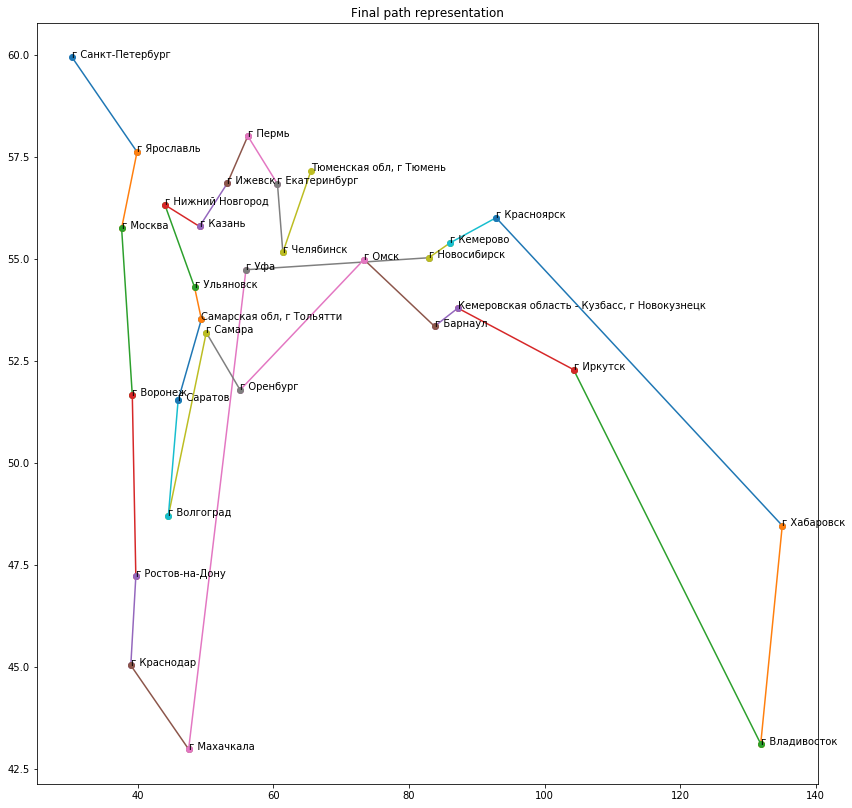

In [32]:
plt.rcParams["figure.figsize"] = [14, 14]
for i in range(1, len(best_path)):
    from_coords = cities30.iloc[best_path[i - 1]][['geo_lon', 'geo_lat']].values
    to_coords = cities30.iloc[best_path[i]][['geo_lon', 'geo_lat']].values
    plt.plot([from_coords[0], to_coords[0]], [from_coords[1], to_coords[1]], '-o')

for idx, name in zip(best_path, best_path_named):
    lat, lon = cities30[['geo_lon', 'geo_lat']].iloc[idx].values
    plt.annotate(name, (lat, lon))

plt.title('Final path representation')
plt.show()

In [35]:
plt.rcParams["figure.figsize"] = [12, 12]
fig, ax = plt.subplots()
plt.close()

ax.set_xlim((25, 150))
ax.set_ylim((42, 61))

for idx, name in zip(best_path, best_path_named):
    lat, lon = cities30[['geo_lon', 'geo_lat']].iloc[idx].values
    ax.annotate(name, (lat, lon))

lines = []
for index in range(len(best_path) - 1):
    lobj, = ax.plot([], [], '-o', lw=2)
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(idx):
    path = path_evolutions[idx]
    res = []
    for i in range(1, len(path)):
        from_coords = cities30.iloc[path[i - 1]][['geo_lon', 'geo_lat']].values
        to_coords = cities30.iloc[path[i]][['geo_lon', 'geo_lat']].values
        x = [from_coords[0], to_coords[0]]
        y = [from_coords[1], to_coords[1]]
        lines[i - 1].set_data(x, y)
    distance = compute_path_distance(cities30, path)
    ax.set_title(f'Best path with distance = {distance}, iter = {idx}')
    return lines
  

anim = animation.FuncAnimation(fig, animate, init_func=init, repeat=False,
                               frames=len(path_evolutions), interval=125, 
                               blit=True) 

rc('animation', html='jshtml')
anim

### P.S: Animation was removed  from the upper cell output in order to decrease weight and performance of the notebook. You can run it yourself or find saved version in `images` folder 

In [34]:
anim.save('images/algo_animation.gif', writer='imagemagick', fps=5) 

MovieWriter imagemagick unavailable. Trying to use pillow instead.
